[View in Colaboratory](https://colab.research.google.com/github/Zulkhuu/head-gesture-recogniton/blob/master/python/head-pose-estimation/head_pose_train_colab.ipynb)

## Show System Specifications

In [1]:
from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"

print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))

Show System RAM Memory:


MemTotal:       13335276 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13231507707848715750
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14350776223529376998
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16274295416149172514
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11276946637
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1030938711548923461
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## Download Dependencies to Google Colab Environment

This may take several minutes but needs to only be run once per session. Every Google Colab session has temporary storage for assets such as images and other scripts. When the session is closed these objects will be removed but the notebook will remain intact.

*Run the cell below to download necessary dependencies. After this is complete you can navigate to the FILES tab on the left and select refresh - you should see the files listed.*


In [2]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

    100% |████████████████████████████████| 993kB 20.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '12zhGg46l-gLp7eZGz_SBXK7eDuN7dyNo'})
download.GetContentFile('HeadPoseImageDatabase_cropped_by_cv_dnn.zip')

In [7]:
!unzip HeadPoseImageDatabase_cropped_by_cv_dnn.zip -d data

Archive:  HeadPoseImageDatabase_cropped_by_cv_dnn.zip
   creating: data/HeadPoseImageDatabase_cropped_by_cv_dnn/
  inflating: data/HeadPoseImageDatabase_cropped_by_cv_dnn/train.csv  
   creating: data/HeadPoseImageDatabase_cropped_by_cv_dnn/Person15/
  inflating: data/HeadPoseImageDatabase_cropped_by_cv_dnn/Person15/person15283+60-30.jpg  
  inflating: data/HeadPoseImageDatabase_cropped_by_cv_dnn/Person15/person15147+0+15.jpg  
  inflating: data/HeadPoseImageDatabase_cropped_by_cv_dnn/Person15/person15215-30-75.jpg  
  inflating: data/HeadPoseImageDatabase_cropped_by_cv_dnn/Person15/person15190+60+75.jpg  
  inflating: data/HeadPoseImageDatabase_cropped_by_cv_dnn/Person15/person15186+60+15.jpg  
  inflating: data/HeadPoseImageDatabase_cropped_by_cv_dnn/Person15/person15170+30-30.jpg  
  inflating: data/HeadPoseImageDatabase_cropped_by_cv_dnn/Person15/person15260+15+15.jpg  
  inflating: data/HeadPoseImageDatabase_cropped_by_cv_dnn/Person15/person15188+60+45.jpg  
  inflating: data/Head

# Loading the data 

In [0]:
import pandas as pd

In [0]:
import_folder = './data/HeadPoseImageDatabase_cropped_by_cv_dnn'
df = pd.read_csv(import_folder+'/train.csv')

In [13]:
df.head(10)

,tilt,pan,facebox,image
0,0,15,[ 72 78 118 120],Person01/person01147+0+15.jpg
1,30,-90,[157 50 100 114],Person01/person01166+30-90.jpg
2,-60,-30,[204 146 105 108],Person01/person01205-60-30.jpg
3,60,0,[101 27 112 85],Person01/person01185+60+0.jpg
4,30,-15,[121 54 108 112],Person01/person01171+30-15.jpg
5,30,0,[103 54 115 118],Person01/person01172+30+0.jpg
6,-30,60,[ 84 126 105 115],Person01/person01224-30+60.jpg
7,-30,45,[100 120 115 109],Person01/person01223-30+45.jpg
8,60,90,[111 24 112 86],Person01/person01191+60+90.jpg
9,0,60,[ 79 86 105 112],Person01/person01250+0+60.jpg


In [14]:
df.shape

(2534, 4)

# Analyzing the data 

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def imread(filename):
    """Load image into a numpy array."""
    return cv2.imread('{:s}/{:s}'.format(import_folder,filename),0)

def plot_faces(nrows=5, ncols=5):
    """Randomly displays some faces from the training data."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_files = df.loc[selection]['image']
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for image_file, ax in zip(image_files, axes.ravel()):
        ax.imshow(imread(image_file), cmap='gray')
        ax.axis('off')

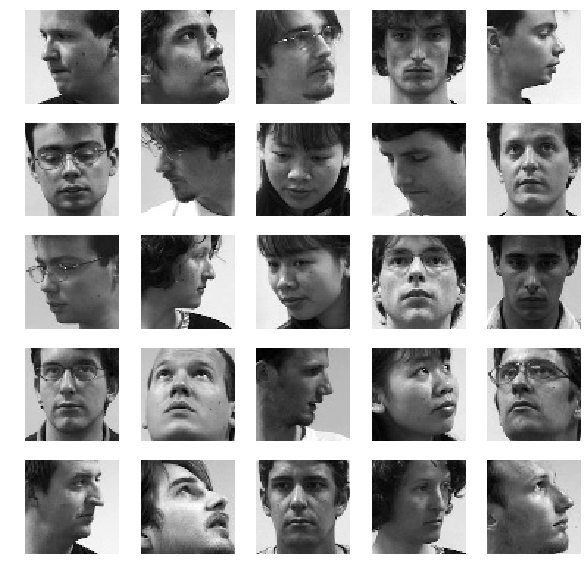

In [17]:
plot_faces()

Let's now add to that plot the facial keypoints that were tagged. First, let's do an example :

In [0]:
pose_cols = list(df.columns)[0:2]

In [19]:
pose = df.iloc[0][pose_cols].values
pose

array([0, 15], dtype=object)

In [0]:
def plot_faces_with_poses(nrows=5, ncols=5):
    """Randomly displays some faces from the training data with their keypoints."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_files = df.loc[selection]['image']
    pose_cols = list(df.columns)[0:2]
    poses = df.loc[selection][pose_cols]
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for image_file, (iloc, pose), ax in zip(image_files, poses.iterrows(), axes.ravel()):
        ax.imshow(imread(image_file), cmap='gray')
        ax.text(3, 5, 'Tilt:{:d} Pan:{:d}'.format(pose[0],pose[1]), fontsize=12,bbox=dict(facecolor='green', alpha=0.8))
        ax.axis('off')

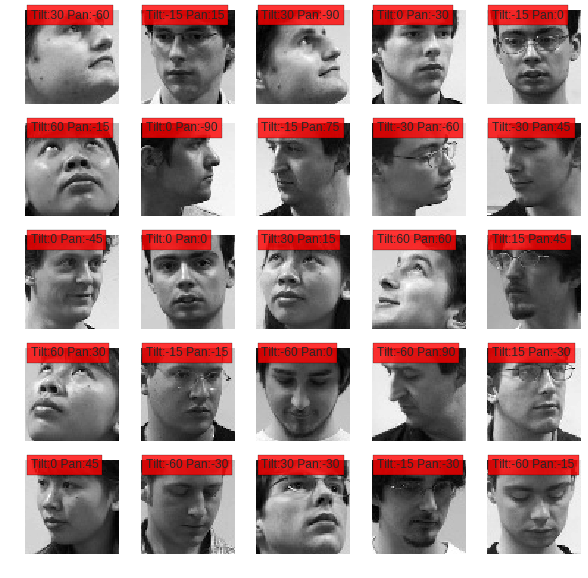

In [22]:
plot_faces_with_poses()

Let's do some statistics about the pose to investigate that last observation :

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc581304438>,
      dtype=object)

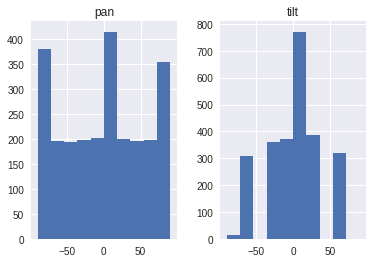

In [23]:
#df.describe().loc['count'].plot.bar()
df.hist()

# Building a Keras model 

Now on to the machine learning part. Let's build a Keras model with our data. Actually, before we do that, let's do some preprocessing first, using the scikit-learn pipelines (inspired by [this great post on scalable Machine Learning by Tom Augspurger](https://tomaugspurger.github.io/scalable-ml-01.html)).

The idea behind pipelining is that it allows you to easily keep track of the data transformations applied to our data. We need two scalings: one for the input and one for the output. Since I couldn't get the scaling to work for 3d image data, we will only use a pipeline for our outputs.

In [0]:
X = np.stack([imread(image_file) for image_file in df['image']]).astype(np.float)[:, :, :, np.newaxis]

In [0]:
y = np.vstack(df[df.columns[0:2]].values)

In [26]:
X.shape, X.dtype

((2534, 64, 64, 1), dtype('float64'))

In [27]:
y.shape, y.dtype

((2534, 2), dtype('int64'))

In [0]:
X_train = X / 255.

In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y_train = output_pipe.fit_transform(y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In this case, the pipelining process is, how to say this, not very spectacular. Let's move on and train a Keras model! We will start with a simple model, as found [in this blog post](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) with a fully connected layer and 100 hidden units.

In [0]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D

# Define models 

In [0]:
from keras.layers import Dropout, Flatten

In [96]:
model = Sequential()
# input layer
model.add(BatchNormalization(input_shape=(64, 64, 1)))
model.add(Conv2D(24, (5, 5), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(36, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(48, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 5
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
# layer 6
#model.add(Dense(500, activation="relu"))
# layer 7
model.add(Dense(32, activation="relu"))
# layer 8
model.add(Dense(2))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_15 (Batc (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 60, 60, 24)        624       
_________________________________________________________________
activation_60 (Activation)   (None, 60, 60, 24)        0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 30, 30, 24)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 30, 30, 24)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 26, 26, 36)        21636     
_________________________________________________________________
activation_61 (Activation)   (None, 26, 26, 36)        0         
__________

In [97]:
from keras import optimizers

#optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.95, nesterov=True)
optimizer = optimizers.Adam(lr=0.0005,beta_1 = 0.9,beta_2 = 0.999)
#optimizer = optimizers.Adam(lr=0.001,beta_1 = 0.9,beta_2 = 0.999,epsilon = 10 ** (-8),clipnorm=1.)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
#model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['accuracy'])
epochs = 50
history = model.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=64)

Train on 2027 samples, validate on 507 samples
Epoch 1/50
2027/2027 [==============================] - 3s 2ms/step - loss: 0.1532 - acc: 0.7568 - val_loss: 0.0674 - val_acc: 0.8836
Epoch 2/50
2027/2027 [==============================] - 1s 376us/step - loss: 0.0546 - acc: 0.8855 - val_loss: 0.0591 - val_acc: 0.8935
Epoch 3/50
2027/2027 [==============================] - 1s 372us/step - loss: 0.0420 - acc: 0.8964 - val_loss: 0.0410 - val_acc: 0.9191
Epoch 4/50
2027/2027 [==============================] - 1s 376us/step - loss: 0.0357 - acc: 0.9156 - val_loss: 0.0406 - val_acc: 0.9172
Epoch 5/50
2027/2027 [==============================] - 1s 375us/step - loss: 0.0308 - acc: 0.9161 - val_loss: 0.0523 - val_acc: 0.9093
Epoch 6/50
2027/2027 [==============================] - 1s 379us/step - loss: 0.0274 - acc: 0.9161 - val_loss: 0.0360 - val_acc: 0.9270
Epoch 7/50
2027/2027 [==============================] - 1s 372us/step - loss: 0.0257 - acc: 0.9235 - val_loss: 0.0375 - val_acc: 0.9112
Epo

Let's see that in curves: 

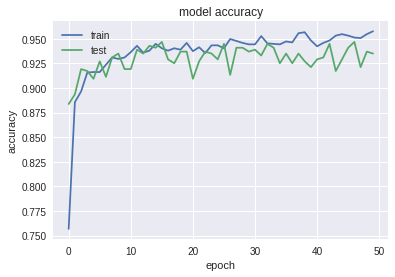

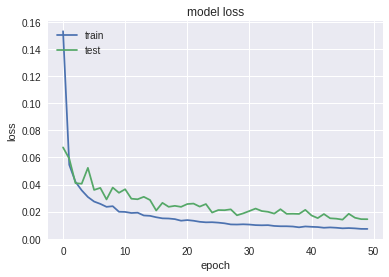

In [98]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

How good is the result?

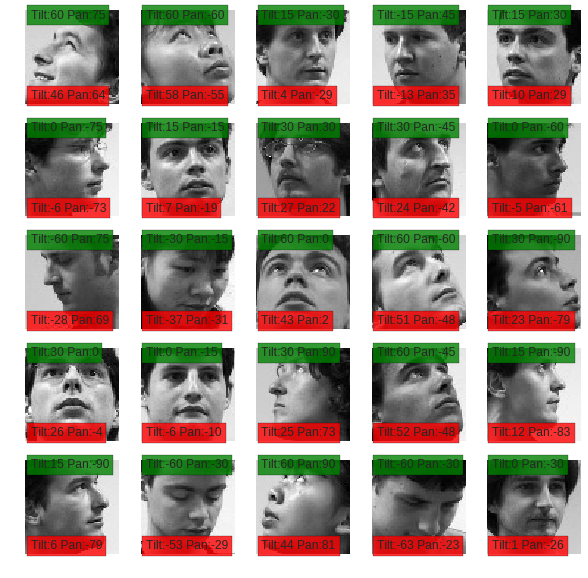

In [99]:
def plot_faces_with_poses_and_predictions(model, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(X.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_train[ind, :, :, 0]
        pose_correct = y[ind].reshape((1,2))
        predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        pose_predictions = output_pipe.inverse_transform(predictions)
        ax.imshow(img, cmap='gray')
        ax.text(3, 60, 'Tilt:{:d} Pan:{:d}'.format(int(pose_predictions[0,0]),int(pose_predictions[0,1])), fontsize=12,bbox=dict(facecolor='red', alpha=0.8))
        ax.text(3, 5, 'Tilt:{:d} Pan:{:d}'.format(int(pose_correct[0,0]),int(pose_correct[0,1])), fontsize=12,bbox=dict(facecolor='green', alpha=0.8))
        ax.axis('off')

plot_faces_with_poses_and_predictions(model, model_input='2d')